In [53]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
from datetime import timedelta
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
import pytz

In [54]:
### ONLY RUN ONCE! ###
#download data from firebase
try:
    firebase_admin.delete_app(app)
except:
    print('making new app')
cred = credentials.Certificate("../../pc_basestation/fb_key.json")
app = firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})


2024-02-02 13:25:01-05:00


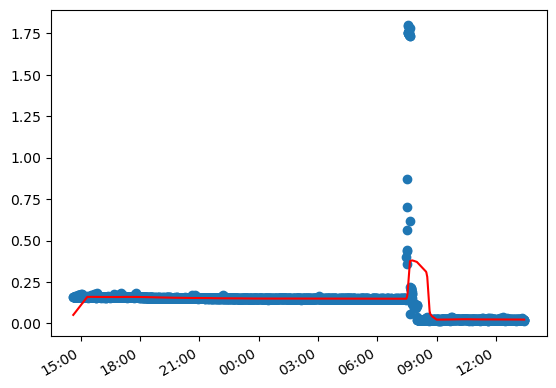

In [60]:
def moving_average(x, n):
    """
    Simple moving average filter
    """
    filter = np.ones(n) / n
    return np.convolve(x, filter, 'valid')

def to_datetime(dates, tz_aware=True):
    """
    Standardizes the various types of string datetime formats
    """
    dt = []
    for i in dates:
        i = i.replace('T','_')
        i = i.replace('-','')
        i = i.replace(' ', '_')
        try:
            i_dt = datetime.strptime(i, '%Y%m%d_%H:%M:%S')
        except:
            print(i)
        if tz_aware:
            tz = pytz.timezone('US/Eastern')
            i_dt = tz.localize(i_dt)

        dt.append(i_dt)
    return np.array(dt)

class egg_sensor():

    def __init__(self, n):
        ref_data = db.reference('/egg_eye_1/data')
        data = dict()
        data['data'] = ref_data.order_by_key().limit_to_last(n).get()
        self.d_dt = to_datetime(data['data'])
        self.on = np.array([int(data['data'][i]['on']) for i in data['data']])
        self.off = np.array([int(data['data'][i]['off']) for i in data['data']])
        self.v = 3.3 * (self.on - self.off)/1023
        self.id = 'egg'

    def plot_timeseries(self, mv):
        # Set date format for x-axis labels
        date_fmt = '%H:%M'
        # Use DateFormatter to set the data to the correct format.
        date_formatter = mdates.DateFormatter(date_fmt, tz=(pytz.timezone("US/Eastern")))
        lower = self.d_dt[-1] - timedelta(days=0, hours=24)
        print(self.d_dt[-1])

        window = (self.d_dt > lower)
        v = moving_average(self.v[window], mv)

        plt.figure()
        plt.plot(self.d_dt[window][mv - 1 :], v, color='r')
        plt.scatter(self.d_dt[window][mv - 1 :], self.v[window][mv - 1 :], alpha=1)
        # plt.ylabel("$\Delta $ Diode Voltage (V)", fontsize=14)
        plt.gcf().autofmt_xdate()
        plt.gca().xaxis.set_major_formatter(date_formatter)

sensor = egg_sensor(n=2*60*32)
sensor.plot_timeseries(mv=120)